<a href="https://colab.research.google.com/github/CB200999/TimeSeriesForcasting/blob/main/TimeSeriesForcasting_with_XGBoost_EnergyConsumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error


color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [119]:
df = pd.read_csv('/content/drive/MyDrive/HourlyEnergyConsumption/PJME_hourly.csv')

In [107]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [120]:
df = df.set_index('Datetime')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2+ MB


In [121]:
df.index = pd.to_datetime(df.index)

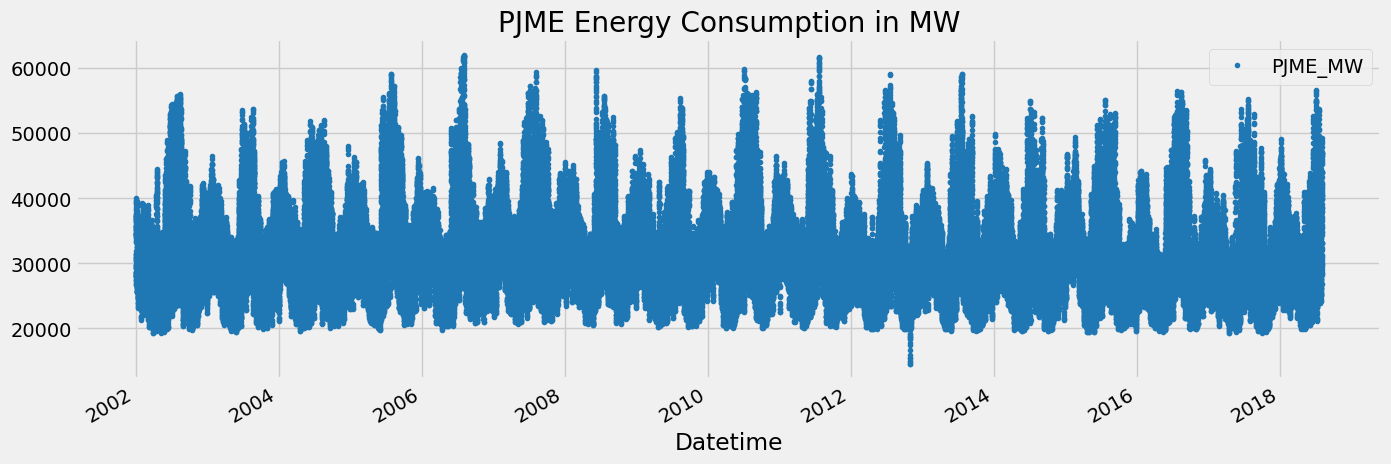

In [25]:
df.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJME Energy Consumption in MW')
plt.show()

In [26]:
# Train Test Split

train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

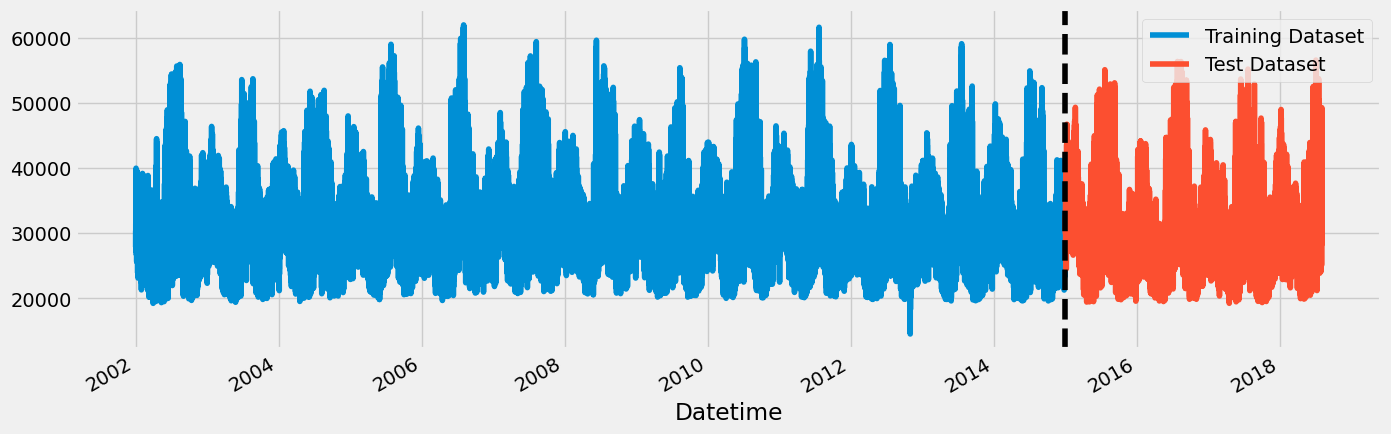

In [30]:
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Dataset')
test.plot(ax=ax, label='Test Dataset')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Dataset', 'Test Dataset'])
plt.show()

<Axes: title={'center': 'One Week of Energy Consumption'}, xlabel='Datetime'>

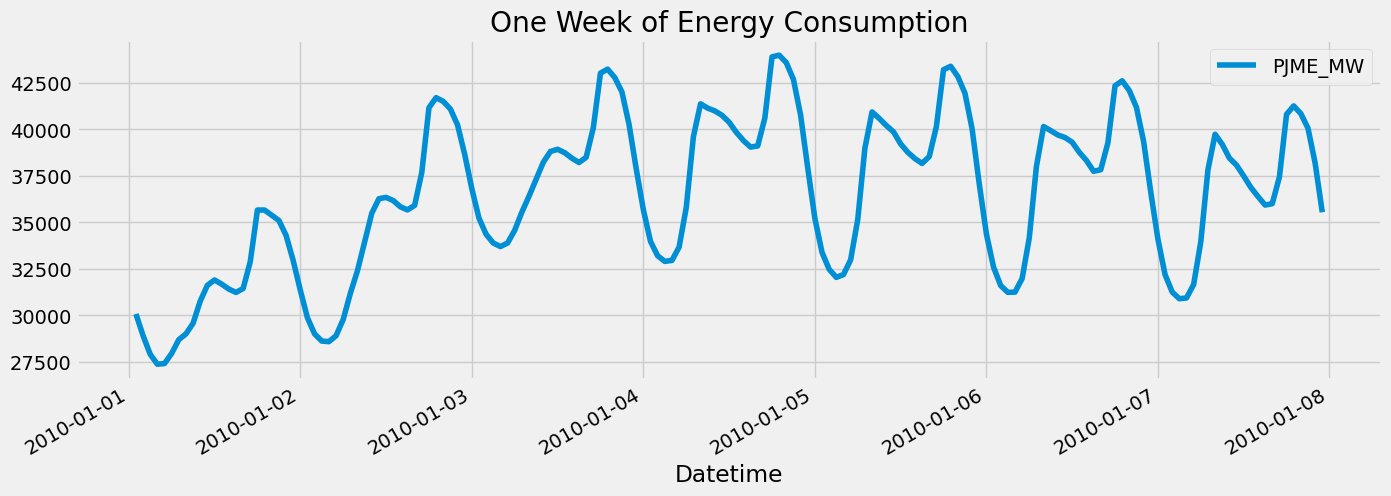

In [34]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(15,5), title='One Week of Energy Consumption')

In [47]:
# Features

def create_features(df):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek #Monday = 0 | Sunday = 6
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    return df

In [52]:
df = create_features(df)

<ipython-input-47-24730d382666>:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


Text(0.5, 1.0, 'MW by hour')

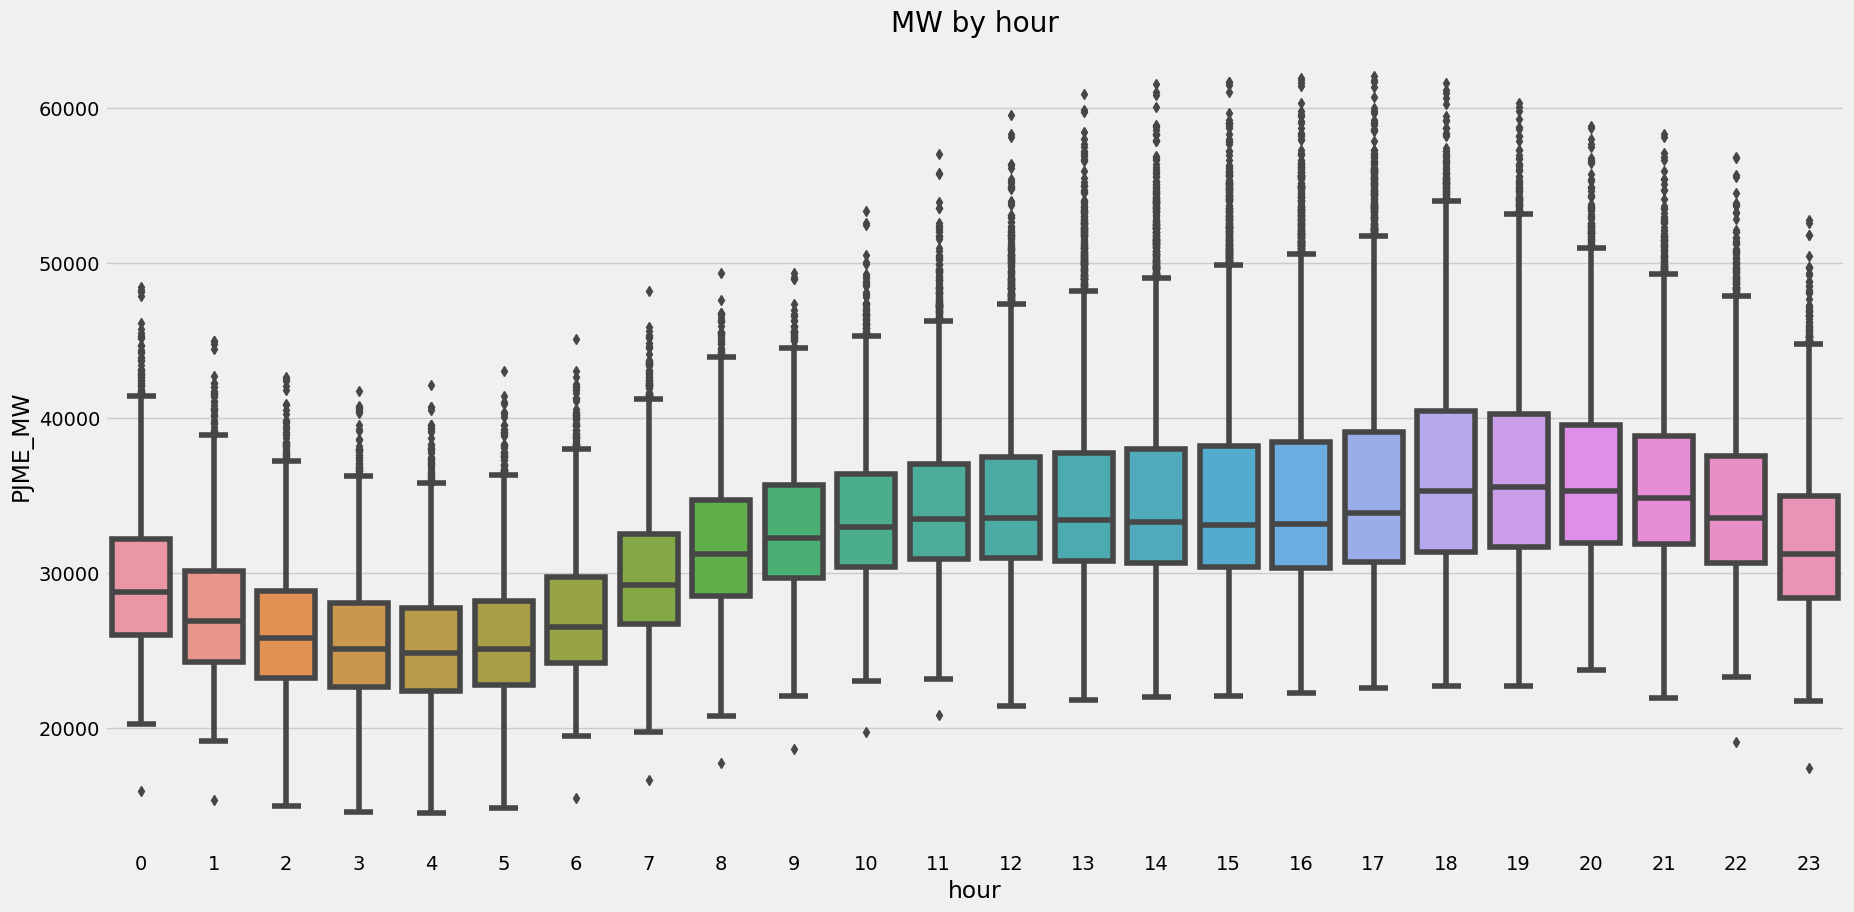

In [55]:
fix, ax = plt.subplots(figsize=(20,10))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by hour')

Text(0.5, 1.0, 'MW by week of the year')

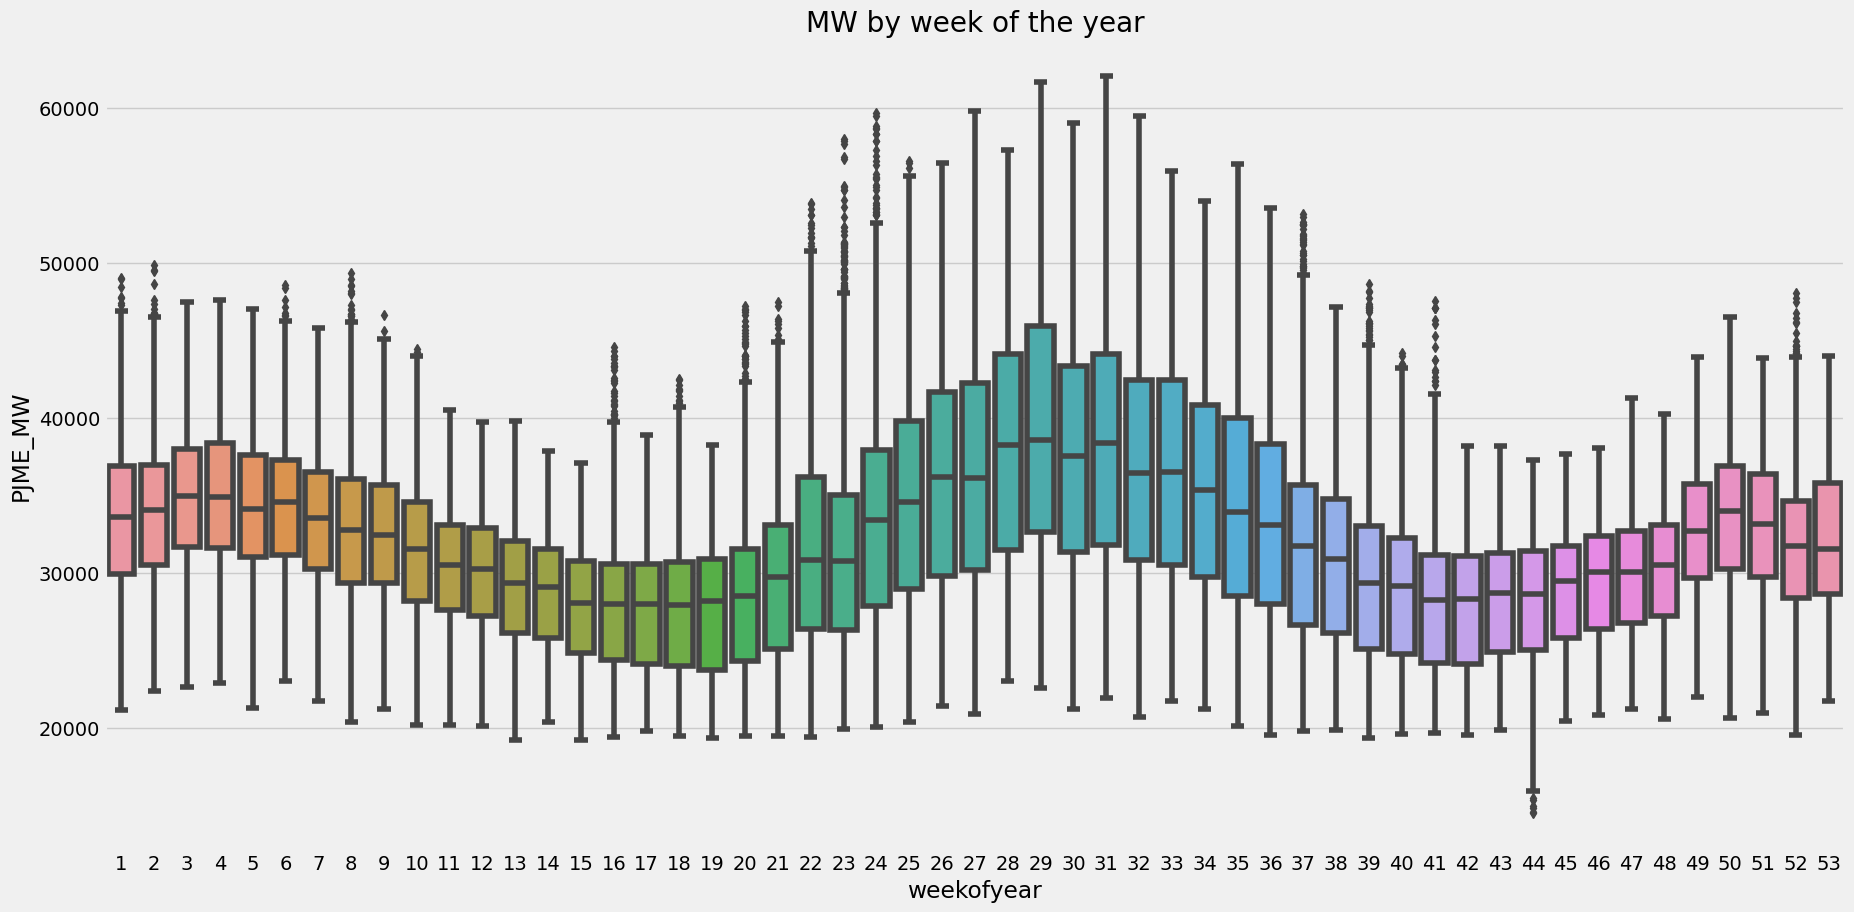

In [57]:
fix, ax = plt.subplots(figsize=(20,10))
sns.boxplot(data=df, x='weekofyear', y='PJME_MW')
ax.set_title('MW by week of the year')

Text(0.5, 1.0, 'MW by month')

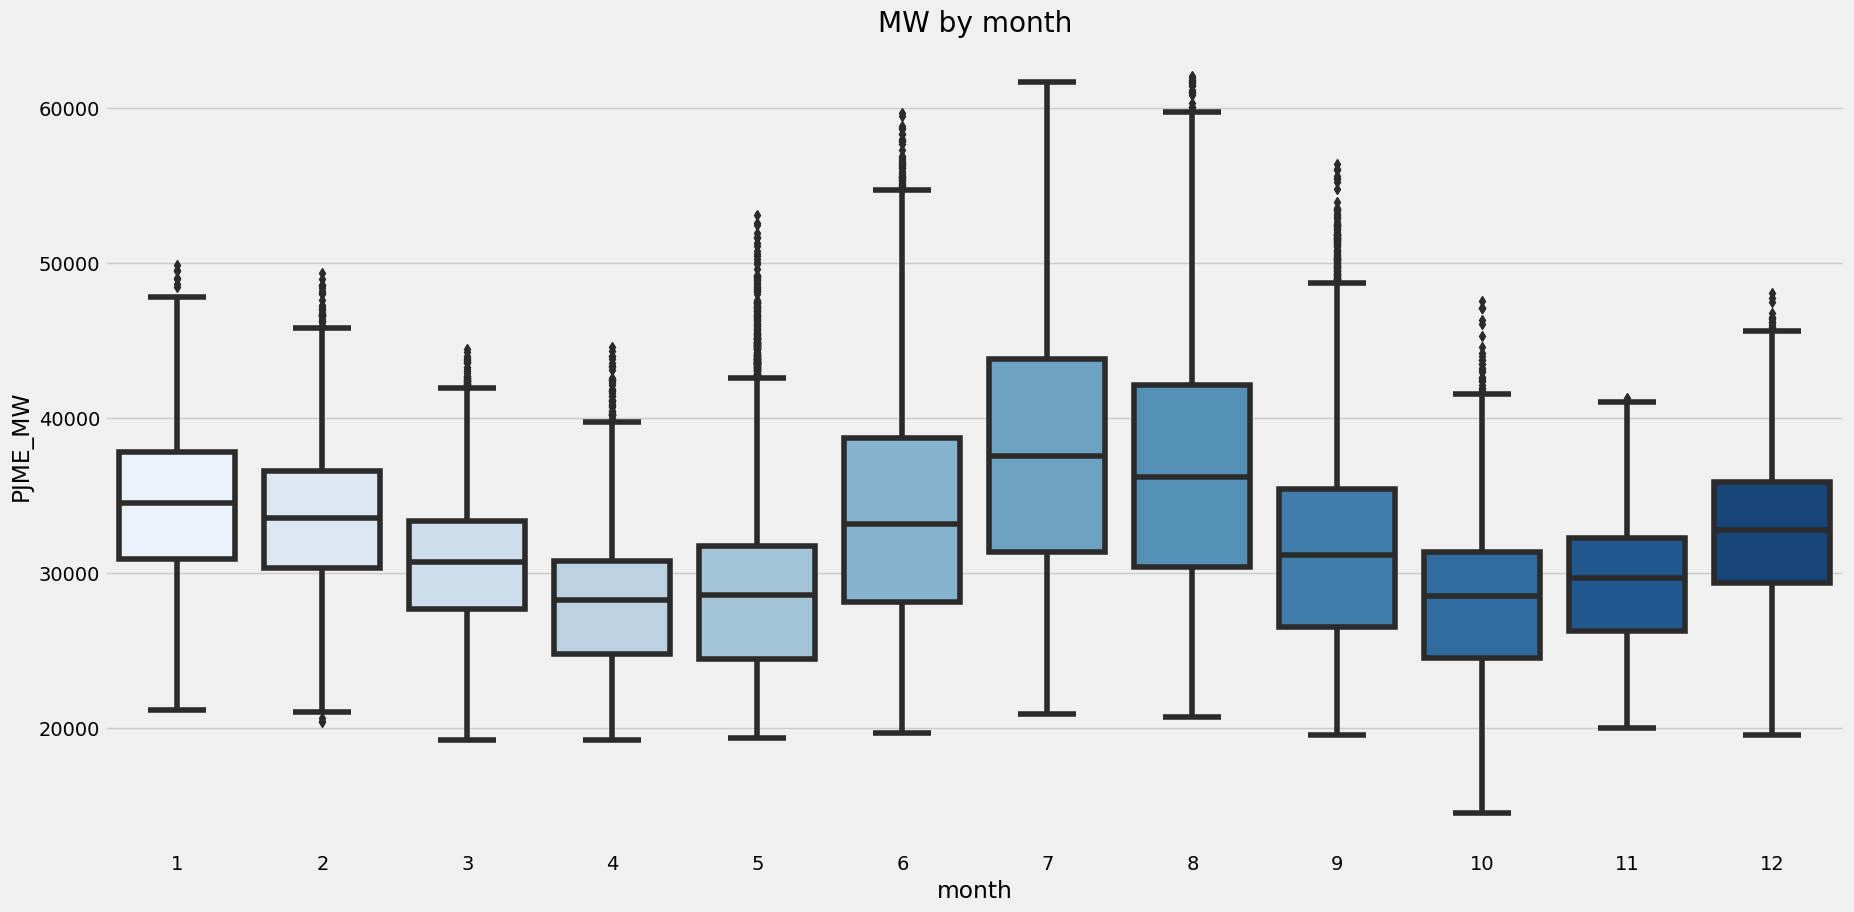

In [58]:
fix, ax = plt.subplots(figsize=(20,10))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by month')

In [60]:
df.columns

Index(['PJME_MW', 'date', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth', 'weekofyear'],
      dtype='object')

In [67]:
Features = ['hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth', 'weekofyear']
Target = ['PJME_MW']

In [68]:
X_train = train[Features]
y_train = train[Target]

X_test = test[Features]
y_test = test[Target]

In [71]:
# create model

model = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:32601.87768	validation_1-rmse:31654.68421
[100]	validation_0-rmse:12341.93512	validation_1-rmse:11516.90737
[200]	validation_0-rmse:5371.61499	validation_1-rmse:5156.86497
[300]	validation_0-rmse:3368.46387	validation_1-rmse:3831.79580
[400]	validation_0-rmse:2872.86038	validation_1-rmse:3713.20489
[440]	validation_0-rmse:2778.92852	validation_1-rmse:3733.06720


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [73]:
# Feature importance
fi = pd.DataFrame(data=model.feature_importances_,
             index = model.feature_names_in_,
             columns=['importance'])

<Axes: title={'center': 'Feature Importance'}>

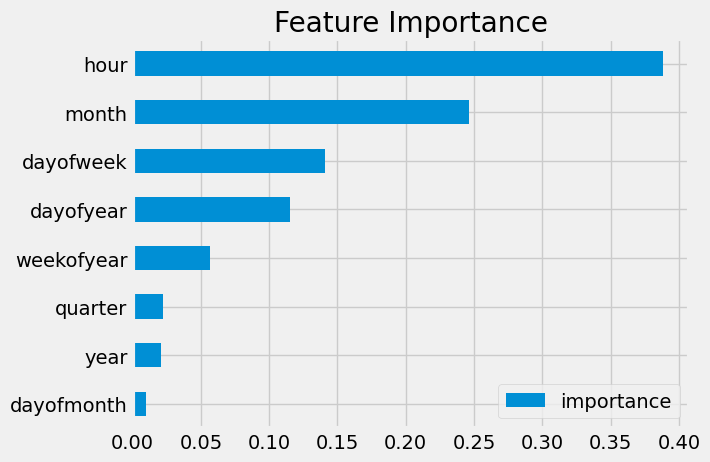

In [74]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')

In [75]:
# forecast

test['prediction'] = model.predict(X_test)

<ipython-input-75-aee748da600b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = model.predict(X_test)


In [80]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

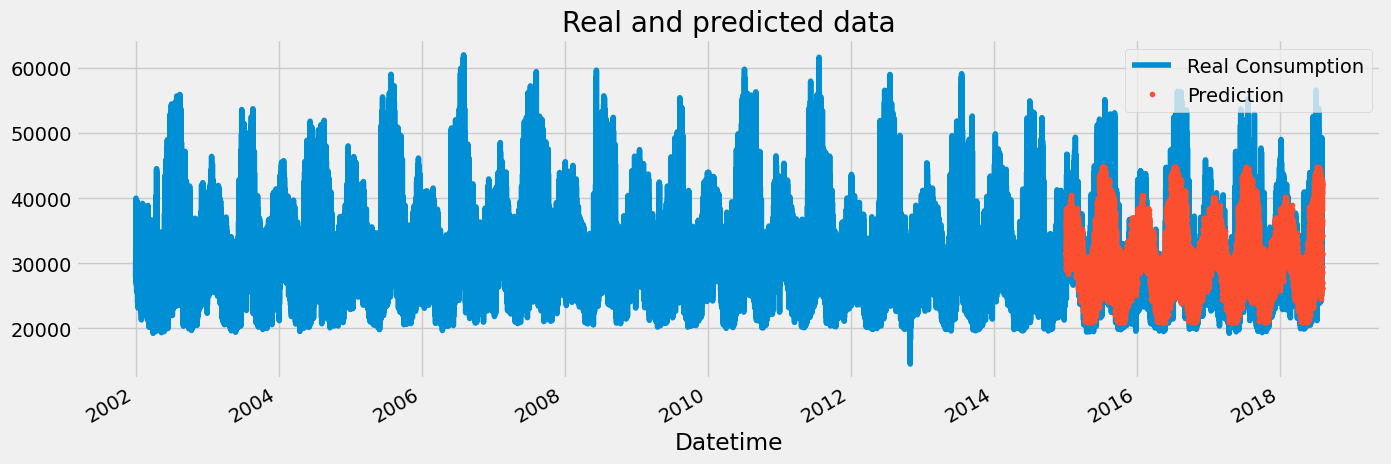

In [84]:
ax = df[['PJME_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Real Consumption', 'Prediction'])
ax.set_title('Real and predicted data')
plt.show()

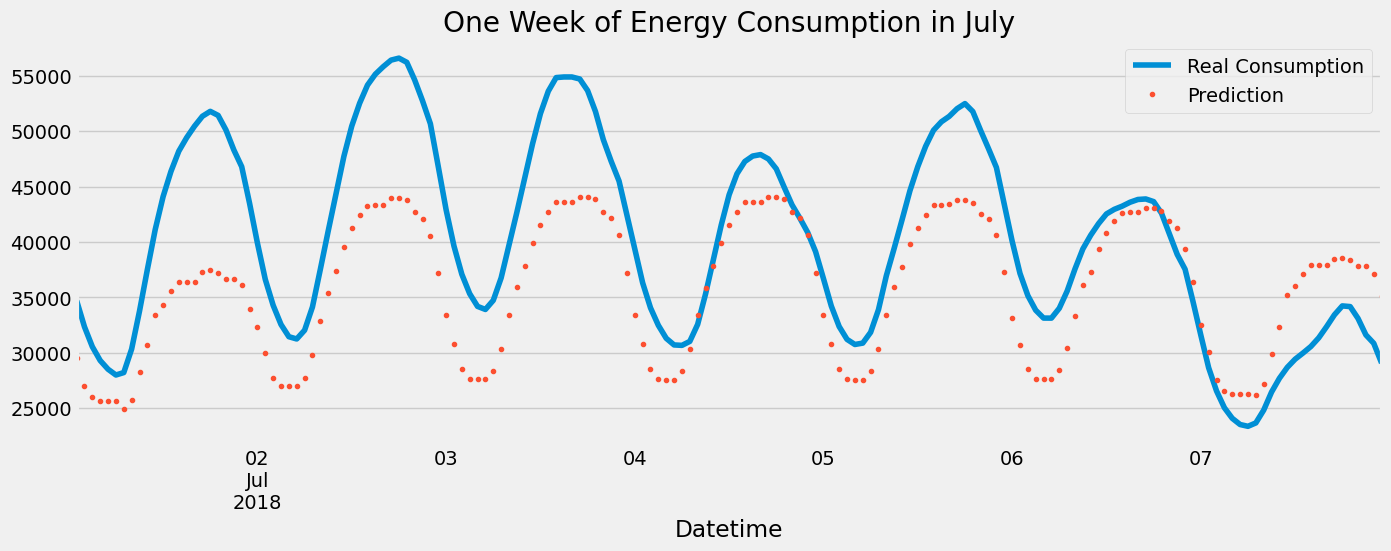

In [87]:
ax = df.loc[(df.index > '07-01-2018') & (df.index < '07-08-2018')]['PJME_MW'].plot(figsize=(15,5), title='One Week of Energy Consumption in July')
df.loc[(df.index > '07-01-2018') & (df.index < '07-08-2018')]['prediction'].plot(style='.')
plt.legend(['Real Consumption', 'Prediction'])
plt.show()

In [90]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score: {score:0.2f}')

RMSE Score: 3712.05


In [92]:
test.head()

,PJME_MW,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
Datetime,,,,,,,,,,,
2015-01-01 00:00:00,32802.0,2015-01-01 00:00:00,0,3,1,1,2015,1,1,1,31663.914062
2015-12-31 01:00:00,24305.0,2015-12-31 01:00:00,1,3,4,12,2015,365,31,53,28467.189453
2015-12-31 02:00:00,23156.0,2015-12-31 02:00:00,2,3,4,12,2015,365,31,53,27223.000000
2015-12-31 03:00:00,22514.0,2015-12-31 03:00:00,3,3,4,12,2015,365,31,53,27038.230469
2015-12-31 04:00:00,22330.0,2015-12-31 04:00:00,4,3,4,12,2015,365,31,53,27038.230469


In [93]:
test['error'] = np.abs(test['PJME_MW'] - test['prediction'])

In [101]:
test['date'] = test.index.date

In [102]:
# best predicted days
test.groupby(['date'])['error'].mean().sort_values().head(20)

date
2016-09-27    307.587402
2015-03-10    436.214600
2016-05-01    492.453288
2016-12-08    514.557210
2016-04-04    514.923503
2017-12-08    518.662354
2015-09-22    524.756022
2016-12-12    525.349609
2015-08-07    531.402669
2015-10-28    534.069661
2015-03-04    534.767090
2016-12-13    562.630127
2018-05-17    567.207682
2016-04-07    574.500488
2017-05-02    575.612549
2015-09-25    580.418701
2017-06-16    588.866292
2015-11-30    591.770508
2016-10-27    593.050049
2015-04-20    596.389079
Name: error, dtype: float64

In [103]:
# worst predicted days 
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(20)

date
2016-08-13    14469.672526
2016-08-14    14389.606201
2016-09-10    12257.577799
2016-08-12    11454.328206
2015-02-20    11149.265706
2016-09-09    11097.124186
2018-01-06    10849.513590
2016-08-11    10411.443522
2015-02-16    10046.735107
2018-01-07    10003.845296
2017-05-19     9989.554281
2015-02-21     9948.087321
2016-07-23     9817.221680
2015-09-09     9555.973796
2016-08-15     9555.737956
2017-12-31     9410.649414
2015-02-15     9315.944661
2016-08-16     9190.796305
2018-01-05     9149.534749
2017-05-18     8667.813639
Name: error, dtype: float64

<Axes: ylabel='Frequency'>

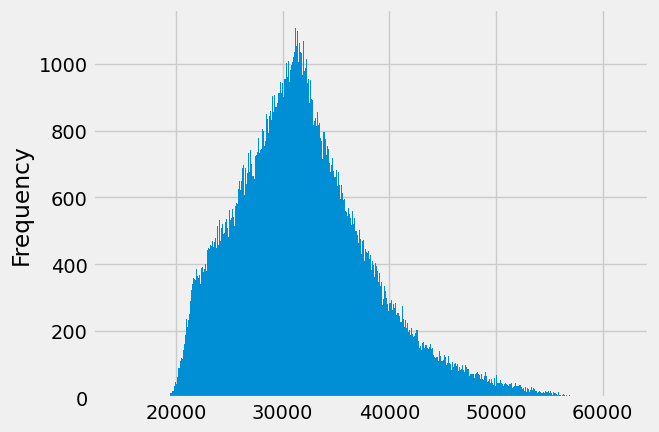

In [122]:
# detecting outliers

df['PJME_MW'].plot(kind='hist', bins=500)

<Axes: xlabel='Datetime'>

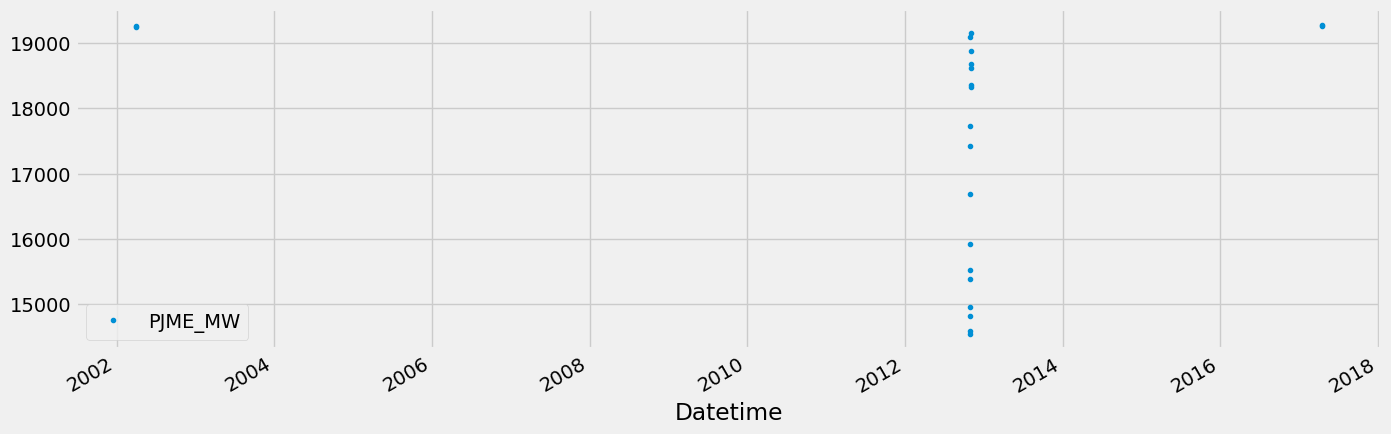

In [123]:
df.query('PJME_MW < 19_300').plot(figsize=(15,5), style='.')

In [124]:
df = df.query('PJME_MW > 19_300').copy()

In [126]:
from sklearn.model_selection import TimeSeriesSplit


In [128]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)

In [129]:
df = df.sort_index()

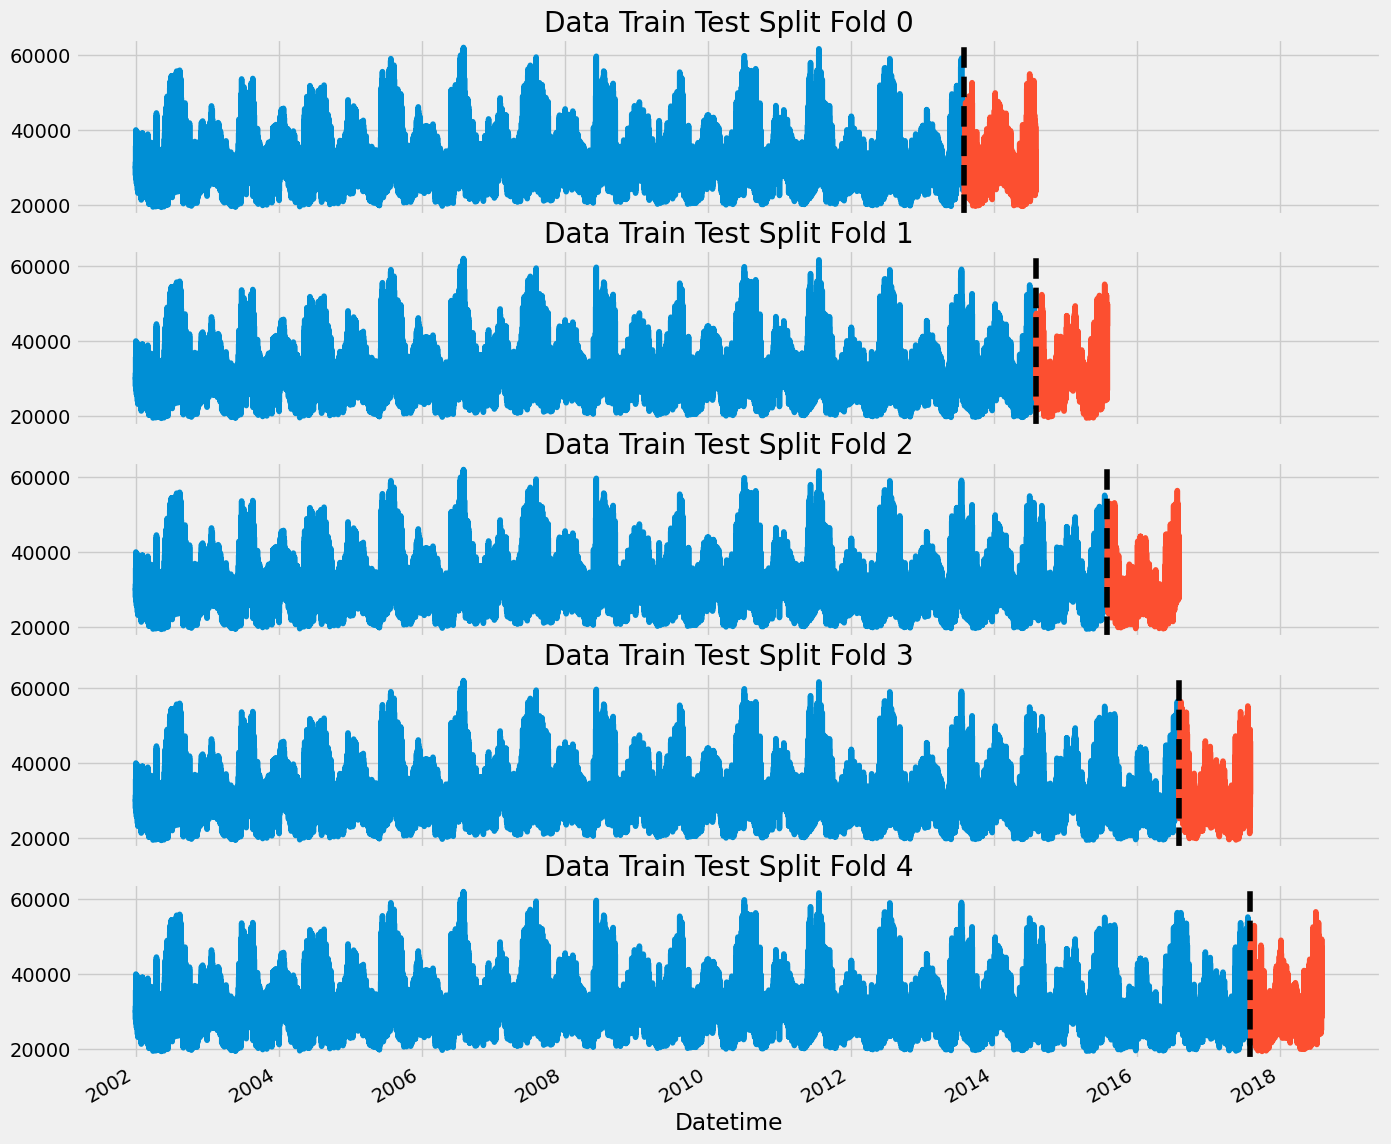

In [141]:
fig, axs = plt.subplots(5,1, figsize=(15,15), sharex=True)

fold=0

for train_idx, val_idx in tss.split(df):
  train = df.iloc[train_idx]
  test = df.iloc[val_idx]
  train['PJME_MW'].plot(ax=axs[fold],
                        label='Training Dataset', 
                        title = f'Data Train Test Split Fold {fold}')
  test['PJME_MW'].plot(ax=axs[fold], label='Test Dataset')
  axs[fold].axvline(test.index.min(), color='black', ls='--')
  fold += 1
